In [1]:
%pylab inline
import os
import sys
import pickle
import feather
import numpy as np
import pandas as pd
import scanpy as sc
#sys.path.append('../seq/')
#import rnaseqTools

from matplotlib import *
import matplotlib.pyplot as plt
rcParams['pdf.fonttype']=42 # in order to save fonttype in AI
rcParams['ps.fonttype']=42

from anaASCFileFuncs import anaResults
from batchExtractMorphFeatures import processEachFile
from morphClassifier import loadDataMatrix

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib
None


In [2]:
# create the color table for neuron clusters.
clusterColors_NeuronTable=np.array([ '#98A14E',   #0
                                    '#008000',    #1
                                    '#2E8B57',     #2
                                    '#96C390',     #3
                                    '#6FBC1E',    #4
                                    '#6D9269',    #5
                                    '#90EE90',    #6
                                    '#224700',   #7  
                                    '#228B22',  # 8
                                    '#00FF7F',     #9
                                    '#ADD8E6',  #'#7CFC00',#  10
                                    '#4666A6',    # 11
                                    '#1E90FF', #'#7FFF00',  #12
                                    '#B4BA77',     #13
                                    '#1B655D',    #14
                                    '#008B8B',    #15
                                    '#00CED1',    #16
                                    '#20B2AA',    #17
                                    '#66CDAA',     #18
                                    '#00FF00',    #19    ### greenish colors for excitatory neurons 
                              
                              '#DDACC9', '#DEB887', '#DD8091', '#7C086C', '#FFD700', '#FF8C97',    #20-25
                              '#FFA388', '#C77963', '#7E0ACB', '#FF4500', '#FF0000', '#9900B3',    #26-31
                              '#C9AE9C', '#AA4DB5', '#FF1493', '#AB1DFF', '#FF5FCD', '#FFC0CB',
                              '#B09FFF', '#DAA520', '#992E81', '#F70CF3', '#FFBF09', '#AB379C',
                              '#F5DEB3', '#7779BF', '#626EB8', '#FFFF00', '#FF8011', '#FF9F2C',
                              '#FF88AD', '#C22B74', '#FFB22B', '#D9C566', '#BE8652',     ### redish colors for inhibttory neurons.
                              ])

In [3]:
# elecFeatTable = './data_ephy/data_ephyio_ins.csv'
elecFeatTable = '../ephysio//data_ephy/Ins_patchseq_ephs.xlsx'
rawEphysFeatures = pd.read_excel(elecFeatTable,'Ins_patchseq_ephs',index_col='cDNA_ID')

predictCluster = rawEphysFeatures.loc[:,'predictCluster']
cellnames = np.array(rawEphysFeatures.index.astype(str))
# rawMorphFeatures.loc[:,'predictCluster'] = rawMorphFeatures['predictCluster'].astype(int)

cellType_expert = rawEphysFeatures['cellType']

In [4]:
cellnames

array(['s170', 's173', 's174', 's175', 's177', 's218', 's219', 's221',
       's222', 's225', 's227', 's209', 's210', 's211', 's212', 's213',
       's214', 's418', 's419', 's422', 's423', 's425', 's426', 's427',
       's428', 's438', 's441', 's442', 's443', 's444', 's461', 's463',
       's464', 's465', 's466', 's467', 's468', 's470', 's471', 's472',
       's473', 's475', 's476', 's481', 's484', 's485', 's486', 's493',
       's495', 's496', 's497', 's498', 's499', 's500', 's501', 's505',
       's506', 's508', 's509', 's515', 's516', 's532', 's533', 's534',
       's535', 's536', 's538', 's539', 's543', 's544', 's546', 's547',
       's548', 's549', 's551', 's553', 's554', 's620', 's621', 's622',
       's623', 's624', 's628', 's629', 's630', 's631', 's647', 's649',
       's655', 's657', 's661', 's666', 's671', 's672', 's673', 's680',
       's681', 's690', 's691', 's692', 's695', 's696', 's698', 's700',
       's702', 's703', 's706', 's712', 's717', 's719', 's720', 's722',
      

In [5]:
predictCluster

cDNA_ID
s170    18
s173    16
s174    16
s175    18
s177    14
        ..
n191    14
n193    15
n197    15
n201     8
n209    18
Name: predictCluster, Length: 277, dtype: int64

In [6]:
clusterNames = ['Exc RORB SCN7A', 'Exc HPCAL1 MEPE', 'Exc RORB CDK2AP1',
                 'Exc FEZF2 RSPO3', 'Exc FEZF2 SMYD1', 'Exc HPCAL1 FREM3', 
                 'Exc FEZF2 LTBP3', 'Exc RORB CYP26B1', 'Exc FEZF2 COL24A1',
                 'Exc RORB DEPTOR', 'Exc FEZF2 HTR2C', 'Exc RORB CHI3L1', 
                 'Exc HPCAL1 FRZB', 'Exc RORB FAP', 'Exc RORB NRG1',
                 'Exc HPCAL1 PENK', 'Exc FEZF2 DSG2', 'Exc HPCAL1 KANK4',
                 'Exc FEZF2 MCUB',  'Exc RORB TRDN ',
                
                 'Inh VIP SCNG', 'Inh SST PENK', 'Inh SST MME', 'Inh LAMP5 RGCC',
                 'Inh SST ANXA2', 'Inh VIP SHISA8', 'Inh VIP SMOC1', 'Inh VIP RASL10A',
                 'Inh SST PTK2B', 'Inh LAMP5 IL13RA1', 'Inh PVALB PVALB',
                 'Inh LAMP5 BCAM', 'Inh VIP CRISPLD1', 'Inh SNCG IGFBP2',
                 'Inh PVALB COL5A2', 'Inh LAMP5 GSTM2', 'Inh LAMP5 BMP2', 
                 'Inh SNCG ARHGAP18', 'Inh SNCG PIK3CG', 'Inh SNCG PDLIM5', 
                 'Inh SST SP5', 'Inh SNCG S100A6', 'Inh SNCG ADRA1D', 'Inh SNCG CDH24', 
                 'Inh SST SLC30A3', 'Inh SNCG KLHL13', 'Inh SERPINF1 DCN', 
                 'Inh SNCG TPM2', 'Inh SNCG C1QL2', 'Inh LAMP5 SERPINF1',
                 'Inh PVALB NKX2-1', 'Inh SST CHODL', 'Inh VIP SLIT1']

In [7]:
# # load the morphlogical features of all cells.
# pkFile_path = './dataMorph/pkFiles' 
# data_Feat, data_label, varNames, pkFileNames = loadDataMatrix(pkFile_path)

morphFeatFile_path = './dataMorph/morphFeatMatrix.csv'
rawMorphFeatures = pd.read_csv(morphFeatFile_path,index_col=0)


In [8]:
rawMorphFeatures

,cellTypeID,allBasalDenLen,apicalLen,axonDist,axonLen,centroid_allBasalDenY,centroid_apicalY,centroid_axonY,height,lengthFractionAboveSoma_apical,...,totalApicalVolume,totalAxonLength,totalAxonVolume,totalBasalLength,totalBasalSurfaceArea,totalBasalVolume,totalLen,totalSurfaceArea,totalVolume,totalAxonSurfaceArea
B112,2,1573.569723,2471.737105,2.492281,679.656167,-40.073408,182.565365,-81.289321,784.30,0.954818,...,1452.852726,679.656132,112.952230,1573.569670,3379.445353,627.588079,4724.962995,10413.655551,2229.522436,982.193300
B15,2,768.102720,2121.989931,0.919874,179.515596,-18.156018,215.944276,-75.341351,683.30,1.000000,...,1153.040061,179.515594,92.504333,768.102694,1970.483373,435.120017,3069.608247,7801.776757,1711.248169,456.811553
B154,2,3573.866010,2851.954476,0.000000,189.843234,-65.531695,129.438833,-72.495039,48.57,1.000000,...,8388.612917,189.837616,279.842268,3573.845681,20466.481440,9415.182072,6615.663719,38444.124952,18318.863781,817.057703
B224,2,1184.024662,598.342024,0.000000,237.092296,46.424543,-20.543718,-63.791752,73.11,0.138517,...,400.311993,237.092293,88.655462,1184.024666,3211.915594,1066.233344,2019.458982,5419.707400,1584.784306,513.944696
B55,2,967.222799,2026.918673,0.000000,47.808631,-33.121463,270.450831,-19.206011,794.80,1.000000,...,1154.282421,47.808636,12.631419,967.222775,2584.927087,581.908382,3041.950102,7672.768624,1759.702103,87.113241
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
s722,1,1390.448694,1203.991459,0.000000,121.033303,-80.376683,127.456794,-57.690645,681.25,0.992922,...,1082.225143,121.033295,45.257749,1390.448693,3692.432813,884.374916,2715.473456,7828.057061,2050.223439,262.363755
s725,1,2161.712022,2429.440311,0.000000,66.087886,-67.492119,367.272940,-32.398086,1243.40,1.000000,...,2316.335561,66.087875,48.232372,2161.712045,4739.931023,874.023682,4657.240219,11984.399768,3257.442440,189.744714
s727,1,3309.298558,4598.691892,0.000000,112.109683,-74.294985,308.267710,-50.322418,1253.20,0.950877,...,4578.785066,112.109673,88.453375,3309.298612,6698.096619,1170.862221,8020.100133,20223.157877,7778.147988,347.307096
s732,1,4575.900822,2557.163073,NaN,NaN,8.578133,199.092911,NaN,656.86,1.000000,...,1461.848069,0.000000,0.000000,4575.900916,8849.595514,1460.721038,NaN,14831.570436,2951.127988,0.000000


In [9]:
# combine the predictCluster info with the morph table data (sort the predictCluster align with the morph index). 
cells = rawMorphFeatures.index
predictCluster = predictCluster[cells].astype(int)

In [10]:
predictCluster[cells].shape

(166,)

In [11]:
plotMorphFeats = array(['allBasalDenLen', 'apicalLen', 
       'centroid_allBasalDenY', 'centroid_apicalY', 
       'height', 
       'lengthFractionAboveSoma_basal',
       'maxApicalY', 'maxBasalRadius', 'maxBranchHeight',
       'maxOrder_apical',
       'maxOrder_basal', 'maxRadialDist_apical', 
       'maxRadialDist_basal', 'minBasalY', 'nApicalBranch', 
       'nBasalBranch', 'nTopForks', 'numNeurite', 
       'numNeurite_basal', 'numSec_apical', 'numSec_basal',
       'shapeFactor_apical', 'shapeFactor_basal',
       'somaArea', 'somaDepth_norm', 'somaRatio1',
       'somaRatio2', 'somaSize', 'soma_radius', 'surfArea', 'thickRatio',
       'topForkPercent', 'topApicalLen', 
       'totalApicalVolume', 
       'totalLen', 'totalSurfaceArea', 'totalVolume'],
      dtype='<U30')
dt = rawMorphFeatures[plotMorphFeats]
X = np.array(dt.copy())

### plot supplementary figure: morphological features comparison among t-type clusters.

(-1.0, 20.0)

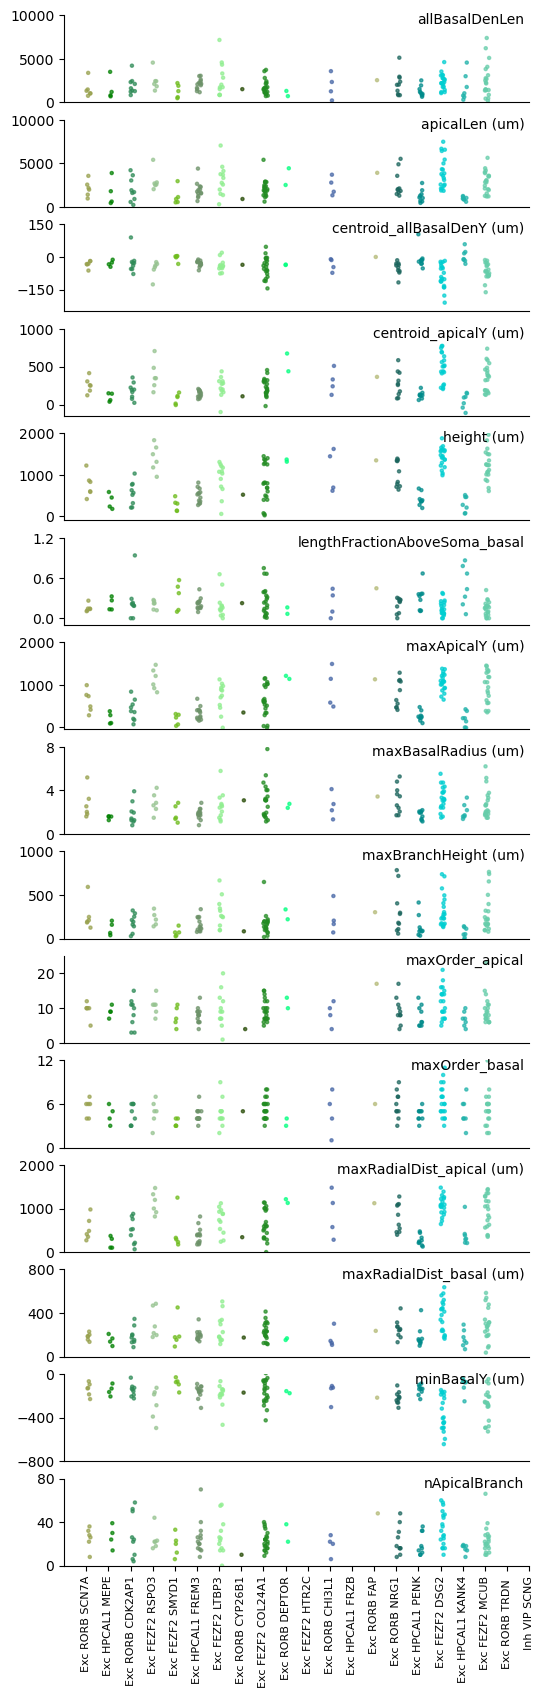

In [12]:
fig = plt.figure( figsize=(6, 50) )
x_axis = np.ones(X.shape[0])
dotsize = 20
nFeatures = X.shape[1]
nCluster = 53

n=0
ax = plt.subplot(nFeatures,1,n+1)
x = predictCluster+np.random.rand(np.sum(  predictCluster.count() ))/5
c= clusterColors_NeuronTable[predictCluster]
scatter = ax.scatter(x,X[:, n], c= clusterColors_NeuronTable[predictCluster], alpha = 0.7,s=dotsize, marker='.')
ax.set_xlim([-1,20])
ax.set_ylim([0,10000])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# plt.yscale('log')
plt.xticks([])
plt.yticks([0,5000,10000])
plt.text(0.99, 0.9, plotMorphFeats[n],transform=ax.transAxes,ha='right',fontsize=10)

n=1
ax = plt.subplot(nFeatures,1,n+1)
x = predictCluster+np.random.rand(np.sum(  predictCluster.count() ))/5
c= clusterColors_NeuronTable[predictCluster]
scatter = ax.scatter(x,X[:, n], c= clusterColors_NeuronTable[predictCluster], alpha = 0.7,s=dotsize, marker='.')
ax.set_xlim([-1,20])
ax.set_ylim([0,10000])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# plt.yscale('log')
plt.xticks([])
plt.yticks([0,5000,10000])
plt.text(0.99, 0.9, plotMorphFeats[n]+' (um)',transform=ax.transAxes,ha='right',fontsize=10)

n=2
ax = plt.subplot(nFeatures,1,n+1)
x = predictCluster+np.random.rand(np.sum(  predictCluster.count() ))/5
c= clusterColors_NeuronTable[predictCluster]
scatter = ax.scatter(x,X[:, n], c= clusterColors_NeuronTable[predictCluster], alpha = 0.7,s=dotsize, marker='.')
ax.set_xlim([-1,20])
ax.set_ylim([-250,150])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# plt.yscale('log')
plt.xticks([])
plt.yticks([-150,0,150])
plt.text(0.99, 0.9, plotMorphFeats[n]+' (um)',transform=ax.transAxes,ha='right',fontsize=10)

n=3
ax = plt.subplot(nFeatures,1,n+1)
x = predictCluster+np.random.rand(np.sum(  predictCluster.count() ))/5
c= clusterColors_NeuronTable[predictCluster]
scatter = ax.scatter(x,X[:, n], c= clusterColors_NeuronTable[predictCluster], alpha = 0.7,s=dotsize, marker='.')
ax.set_xlim([-1,20])
ax.set_ylim([-150,1000])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# plt.yscale('log')
plt.xticks([])
plt.yticks([0,500,1000])
plt.text(0.99, 0.9, plotMorphFeats[n]+' (um)',transform=ax.transAxes,ha='right',fontsize=10)

n=4
ax = plt.subplot(nFeatures,1,n+1)
x = predictCluster+np.random.rand(np.sum(  predictCluster.count() ))/5
c= clusterColors_NeuronTable[predictCluster]
scatter = ax.scatter(x,X[:, n], c= clusterColors_NeuronTable[predictCluster], alpha = 0.7,s=dotsize, marker='.')
ax.set_xlim([-1,20])
ax.set_ylim([-100,2000])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# plt.yscale('log')
plt.xticks([])
plt.yticks([0,1000,2000])
plt.text(0.99, 0.9, plotMorphFeats[n]+' (um)',transform=ax.transAxes,ha='right',fontsize=10)

n=5
ax = plt.subplot(nFeatures,1,n+1)
x = predictCluster+np.random.rand(np.sum(  predictCluster.count() ))/5
c= clusterColors_NeuronTable[predictCluster]
scatter = ax.scatter(x,X[:, n], c= clusterColors_NeuronTable[predictCluster], alpha = 0.7,s=dotsize, marker='.')
ax.set_xlim([-1,20])
ax.set_ylim([-0.1,1.2])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# plt.yscale('log')
plt.xticks([])
plt.yticks([0,0.6,1.2])
plt.text(0.99, 0.9, plotMorphFeats[n],transform=ax.transAxes,ha='right',fontsize=10)

n=6
ax = plt.subplot(nFeatures,1,n+1)
x = predictCluster+np.random.rand(np.sum(  predictCluster.count() ))/5
c= clusterColors_NeuronTable[predictCluster]
scatter = ax.scatter(x,X[:, n], c= clusterColors_NeuronTable[predictCluster], alpha = 0.7,s=dotsize, marker='.')
ax.set_xlim([-1,20])
ax.set_ylim([-50,2000])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# plt.yscale('log')
plt.xticks([])
plt.yticks([0,1000,2000])
plt.text(0.99, 0.9, plotMorphFeats[n]+' (um)',transform=ax.transAxes,ha='right',fontsize=10)

n=7
ax = plt.subplot(nFeatures,1,n+1)
x = predictCluster+np.random.rand(np.sum(  predictCluster.count() ))/5
c= clusterColors_NeuronTable[predictCluster]
scatter = ax.scatter(x,X[:, n], c= clusterColors_NeuronTable[predictCluster], alpha = 0.7,s=dotsize, marker='.')
ax.set_xlim([-1,20])
ax.set_ylim([0,8])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# plt.yscale('log')
plt.xticks([])
plt.yticks([0,4,8])
plt.text(0.99, 0.9, plotMorphFeats[n]+' (um)',transform=ax.transAxes,ha='right',fontsize=10)

n=8
ax = plt.subplot(nFeatures,1,n+1)
x = predictCluster+np.random.rand(np.sum(  predictCluster.count() ))/5
c= clusterColors_NeuronTable[predictCluster]
scatter = ax.scatter(x,X[:, n], c= clusterColors_NeuronTable[predictCluster], alpha = 0.7,s=dotsize, marker='.')
ax.set_xlim([-1,20])
ax.set_ylim([0,1000])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# plt.yscale('log')
plt.xticks([])
plt.yticks([0,500,1000])
plt.text(0.99, 0.9, plotMorphFeats[n]+' (um)',transform=ax.transAxes,ha='right',fontsize=10)

n=9
ax = plt.subplot(nFeatures,1,n+1)
x = predictCluster+np.random.rand(np.sum(  predictCluster.count() ))/5
c= clusterColors_NeuronTable[predictCluster]
scatter = ax.scatter(x,X[:, n], c= clusterColors_NeuronTable[predictCluster], alpha = 0.7,s=dotsize, marker='.')
ax.set_xlim([-1,20])
ax.set_ylim([0,25])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# plt.yscale('log')
plt.xticks([])
plt.yticks([0,10,20])
plt.text(0.99, 0.9, plotMorphFeats[n],transform=ax.transAxes,ha='right',fontsize=10)

n=10
ax = plt.subplot(nFeatures,1,n+1)
x = predictCluster+np.random.rand(np.sum(  predictCluster.count() ))/5
c= clusterColors_NeuronTable[predictCluster]
scatter = ax.scatter(x,X[:, n], c= clusterColors_NeuronTable[predictCluster], alpha = 0.7,s=dotsize, marker='.')
ax.set_xlim([-1,20])
ax.set_ylim([0,12])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# plt.yscale('log')
plt.xticks([])
plt.yticks([0,6,12])
plt.text(0.99, 0.9, plotMorphFeats[n],transform=ax.transAxes,ha='right',fontsize=10)

n=11
ax = plt.subplot(nFeatures,1,n+1)
x = predictCluster+np.random.rand(np.sum(  predictCluster.count() ))/5
c= clusterColors_NeuronTable[predictCluster]
scatter = ax.scatter(x,X[:, n], c= clusterColors_NeuronTable[predictCluster], alpha = 0.7,s=dotsize, marker='.')
ax.set_xlim([-1,20])
ax.set_ylim([0,2000])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# plt.yscale('log')
plt.xticks([])
plt.yticks([0,1000,2000])
plt.text(0.99, 0.9, plotMorphFeats[n]+' (um)',transform=ax.transAxes,ha='right',fontsize=10)

n=12
ax = plt.subplot(nFeatures,1,n+1)
x = predictCluster+np.random.rand(np.sum(  predictCluster.count() ))/5
c= clusterColors_NeuronTable[predictCluster]
scatter = ax.scatter(x,X[:, n], c= clusterColors_NeuronTable[predictCluster], alpha = 0.7,s=dotsize, marker='.')
ax.set_xlim([-1,20])
ax.set_ylim([0,800])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# plt.yscale('log')
plt.xticks([])
plt.yticks([0,400,800])
plt.text(0.99, 0.9, plotMorphFeats[n]+' (um)',transform=ax.transAxes,ha='right',fontsize=10)

n=13
ax = plt.subplot(nFeatures,1,n+1)
x = predictCluster+np.random.rand(np.sum(  predictCluster.count() ))/5
c= clusterColors_NeuronTable[predictCluster]
scatter = ax.scatter(x,X[:, n], c= clusterColors_NeuronTable[predictCluster], alpha = 0.7,s=dotsize, marker='.')
ax.set_xlim([-1,20])
ax.set_ylim([-800,0])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# plt.yscale('log')
plt.xticks([])
plt.yticks([-800,-400,0])
plt.text(0.99, 0.9, plotMorphFeats[n]+' (um)',transform=ax.transAxes,ha='right',fontsize=10)

n=14
ax = plt.subplot(nFeatures,1,n+1)
x = predictCluster+np.random.rand(np.sum(  predictCluster.count() ))/5
c= clusterColors_NeuronTable[predictCluster]
scatter = ax.scatter(x,X[:, n], c= clusterColors_NeuronTable[predictCluster], alpha = 0.7,s=dotsize, marker='.')
ax.set_xlim([-1,20])
ax.set_ylim([-0,80])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# plt.yscale('log')
# plt.xticks([])
plt.yticks([0,40,80])
plt.text(0.99, 0.9, plotMorphFeats[n],transform=ax.transAxes,ha='right',fontsize=10)

plt.xticks(range(nCluster), clusterNames, rotation=90, fontsize=8)
ax.set_xlim([-1,20])

# plt.savefig('./figures/morphFeatCmp_byCluster1.png',dpi=600);
# plt.savefig('./figures/morphFeatCmp_byCluster1.pdf');

(-1.0, 20.0)

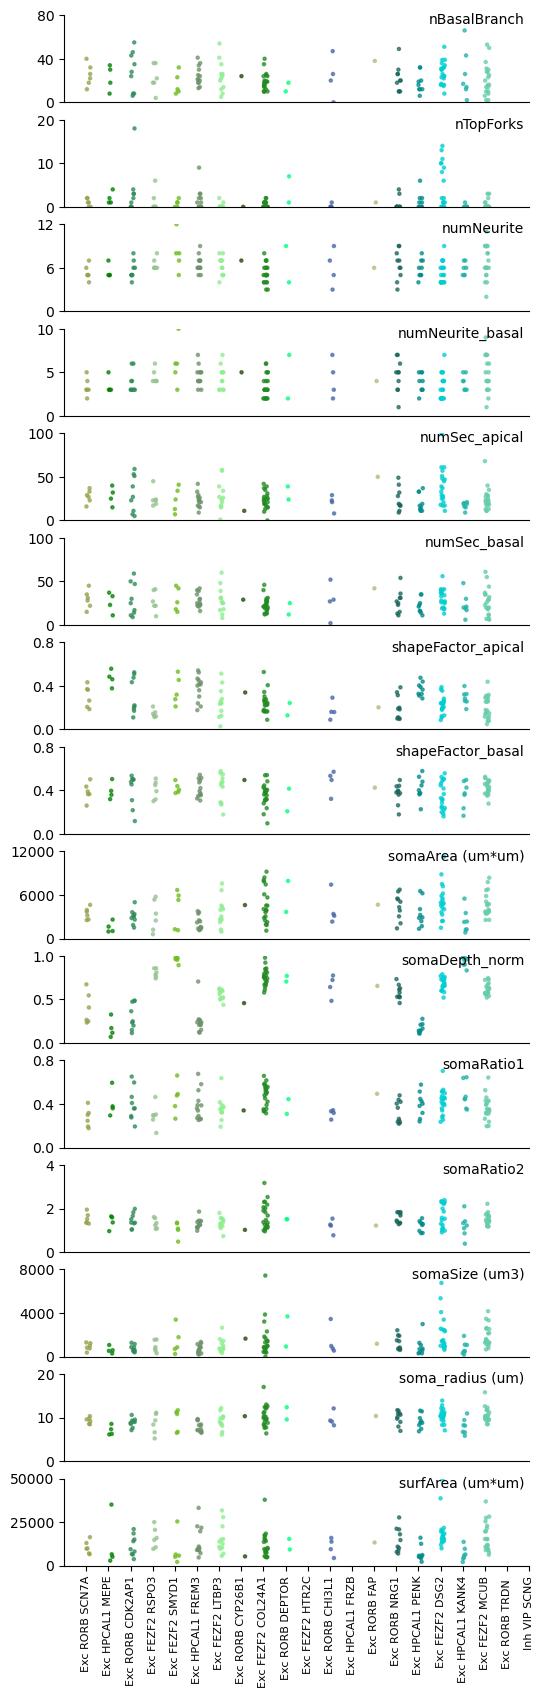

In [13]:
fig = plt.figure( figsize=(6, 50) )
x_axis = np.ones(X.shape[0])
dotsize = 20
nFeatures = X.shape[1]
nCluster = 53

n=15
ax = plt.subplot(nFeatures,1,n+1)
x = predictCluster+np.random.rand(np.sum(  predictCluster.count() ))/5
c= clusterColors_NeuronTable[predictCluster]
scatter = ax.scatter(x,X[:, n], c= clusterColors_NeuronTable[predictCluster], alpha = 0.7,s=dotsize, marker='.')
ax.set_xlim([-1,20])
ax.set_ylim([-0,80])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# plt.yscale('log')
plt.xticks([])
plt.yticks([0,40,80])
plt.text(0.99, 0.9, plotMorphFeats[n],transform=ax.transAxes,ha='right',fontsize=10)

n=16
ax = plt.subplot(nFeatures,1,n+1)
x = predictCluster+np.random.rand(np.sum(  predictCluster.count() ))/5
c= clusterColors_NeuronTable[predictCluster]
scatter = ax.scatter(x,X[:, n], c= clusterColors_NeuronTable[predictCluster], alpha = 0.7,s=dotsize, marker='.')
ax.set_xlim([-1,20])
ax.set_ylim([-0,20])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# plt.yscale('log')
plt.xticks([])
plt.yticks([0,10,20])
plt.text(0.99, 0.9, plotMorphFeats[n],transform=ax.transAxes,ha='right',fontsize=10)

n=17
ax = plt.subplot(nFeatures,1,n+1)
x = predictCluster+np.random.rand(np.sum(  predictCluster.count() ))/5
c= clusterColors_NeuronTable[predictCluster]
scatter = ax.scatter(x,X[:, n], c= clusterColors_NeuronTable[predictCluster], alpha = 0.7,s=dotsize, marker='.')
ax.set_xlim([-1,20])
ax.set_ylim([-0,12])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# plt.yscale('log')
plt.xticks([])
plt.yticks([0,6,12])
plt.text(0.99, 0.9, plotMorphFeats[n],transform=ax.transAxes,ha='right',fontsize=10)

n=18
ax = plt.subplot(nFeatures,1,n+1)
x = predictCluster+np.random.rand(np.sum(  predictCluster.count() ))/5
c= clusterColors_NeuronTable[predictCluster]
scatter = ax.scatter(x,X[:, n], c= clusterColors_NeuronTable[predictCluster], alpha = 0.7,s=dotsize, marker='.')
ax.set_xlim([-1,20])
ax.set_ylim([-0,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# plt.yscale('log')
plt.xticks([])
plt.yticks([0,5,10])
plt.text(0.99, 0.9, plotMorphFeats[n],transform=ax.transAxes,ha='right',fontsize=10)

n=19
ax = plt.subplot(nFeatures,1,n+1)
x = predictCluster+np.random.rand(np.sum(  predictCluster.count() ))/5
c= clusterColors_NeuronTable[predictCluster]
scatter = ax.scatter(x,X[:, n], c= clusterColors_NeuronTable[predictCluster], alpha = 0.7,s=dotsize, marker='.')
ax.set_xlim([-1,20])
ax.set_ylim([-0,100])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# plt.yscale('log')
plt.xticks([])
plt.yticks([0,50,100])
plt.text(0.99, 0.9, plotMorphFeats[n],transform=ax.transAxes,ha='right',fontsize=10)

n=20
ax = plt.subplot(nFeatures,1,n+1)
x = predictCluster+np.random.rand(np.sum(  predictCluster.count() ))/5
c= clusterColors_NeuronTable[predictCluster]
scatter = ax.scatter(x,X[:, n], c= clusterColors_NeuronTable[predictCluster], alpha = 0.7,s=dotsize, marker='.')
ax.set_xlim([-1,20])
ax.set_ylim([-0,100])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# plt.yscale('log')
plt.xticks([])
plt.yticks([0,50,100])
plt.text(0.99, 0.9, plotMorphFeats[n],transform=ax.transAxes,ha='right',fontsize=10)

n=21
ax = plt.subplot(nFeatures,1,n+1)
x = predictCluster+np.random.rand(np.sum(  predictCluster.count() ))/5
c= clusterColors_NeuronTable[predictCluster]
scatter = ax.scatter(x,X[:, n], c= clusterColors_NeuronTable[predictCluster], alpha = 0.7,s=dotsize, marker='.')
ax.set_xlim([-1,20])
ax.set_ylim([-0,0.8])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# plt.yscale('log')
plt.xticks([])
plt.yticks([0,0.4,0.8])
plt.text(0.99, 0.9, plotMorphFeats[n],transform=ax.transAxes,ha='right',fontsize=10)

n=22
ax = plt.subplot(nFeatures,1,n+1)
x = predictCluster+np.random.rand(np.sum(  predictCluster.count() ))/5
c= clusterColors_NeuronTable[predictCluster]
scatter = ax.scatter(x,X[:, n], c= clusterColors_NeuronTable[predictCluster], alpha = 0.7,s=dotsize, marker='.')
ax.set_xlim([-1,20])
ax.set_ylim([-0,0.8])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# plt.yscale('log')
plt.xticks([])
plt.yticks([0,0.4,0.8])
plt.text(0.99, 0.9, plotMorphFeats[n],transform=ax.transAxes,ha='right',fontsize=10)

n=23
ax = plt.subplot(nFeatures,1,n+1)
x = predictCluster+np.random.rand(np.sum(  predictCluster.count() ))/5
c= clusterColors_NeuronTable[predictCluster]
scatter = ax.scatter(x,X[:, n], c= clusterColors_NeuronTable[predictCluster], alpha = 0.7,s=dotsize, marker='.')
ax.set_xlim([-1,20])
ax.set_ylim([-0,12000])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# plt.yscale('log')
plt.xticks([])
plt.yticks([0,6000,12000])
plt.text(0.99, 0.9, plotMorphFeats[n]+' (um*um)',transform=ax.transAxes,ha='right',fontsize=10)

n=24
ax = plt.subplot(nFeatures,1,n+1)
x = predictCluster+np.random.rand(np.sum(  predictCluster.count() ))/5
c= clusterColors_NeuronTable[predictCluster]
scatter = ax.scatter(x,X[:, n], c= clusterColors_NeuronTable[predictCluster], alpha = 0.7,s=dotsize, marker='.')
ax.set_xlim([-1,20])
ax.set_ylim([-0,1])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# plt.yscale('log')
plt.xticks([])
plt.yticks([0,0.5,1])
plt.text(0.99, 0.9, plotMorphFeats[n],transform=ax.transAxes,ha='right',fontsize=10)

n=25
ax = plt.subplot(nFeatures,1,n+1)
x = predictCluster+np.random.rand(np.sum(  predictCluster.count() ))/5
c= clusterColors_NeuronTable[predictCluster]
scatter = ax.scatter(x,X[:, n], c= clusterColors_NeuronTable[predictCluster], alpha = 0.7,s=dotsize, marker='.')
ax.set_xlim([-1,20])
ax.set_ylim([-0,0.8])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# plt.yscale('log')
plt.xticks([])
plt.yticks([0,0.4,0.8])
plt.text(0.99, 0.9, plotMorphFeats[n],transform=ax.transAxes,ha='right',fontsize=10)

n=26
ax = plt.subplot(nFeatures,1,n+1)
x = predictCluster+np.random.rand(np.sum(  predictCluster.count() ))/5
c= clusterColors_NeuronTable[predictCluster]
scatter = ax.scatter(x,X[:, n], c= clusterColors_NeuronTable[predictCluster], alpha = 0.7,s=dotsize, marker='.')
ax.set_xlim([-1,20])
ax.set_ylim([-0,4])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# plt.yscale('log')
plt.xticks([])
plt.yticks([0,2,4])
plt.text(0.99, 0.9, plotMorphFeats[n],transform=ax.transAxes,ha='right',fontsize=10)

n=27
ax = plt.subplot(nFeatures,1,n+1)
x = predictCluster+np.random.rand(np.sum(  predictCluster.count() ))/5
c= clusterColors_NeuronTable[predictCluster]
scatter = ax.scatter(x,X[:, n], c= clusterColors_NeuronTable[predictCluster], alpha = 0.7,s=dotsize, marker='.')
ax.set_xlim([-1,20])
ax.set_ylim([-0,8000])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# plt.yscale('log')
plt.xticks([])
plt.yticks([0,4000,8000])
plt.text(0.99, 0.9, plotMorphFeats[n]+' (um3)',transform=ax.transAxes,ha='right',fontsize=10)

n=28
ax = plt.subplot(nFeatures,1,n+1)
x = predictCluster+np.random.rand(np.sum(  predictCluster.count() ))/5
c= clusterColors_NeuronTable[predictCluster]
scatter = ax.scatter(x,X[:, n], c= clusterColors_NeuronTable[predictCluster], alpha = 0.7,s=dotsize, marker='.')
ax.set_xlim([-1,20])
ax.set_ylim([-0,20])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# plt.yscale('log')
plt.xticks([])
plt.yticks([0,10,20])
plt.text(0.99, 0.9, plotMorphFeats[n]+' (um)',transform=ax.transAxes,ha='right',fontsize=10)

n=29
ax = plt.subplot(nFeatures,1,n+1)
x = predictCluster+np.random.rand(np.sum(  predictCluster.count() ))/5
c= clusterColors_NeuronTable[predictCluster]
scatter = ax.scatter(x,X[:, n], c= clusterColors_NeuronTable[predictCluster], alpha = 0.7,s=dotsize, marker='.')
ax.set_xlim([-1,20])
ax.set_ylim([-0,50000])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# plt.yscale('log')
plt.xticks([])
plt.yticks([0,25000,50000])
plt.text(0.99, 0.9, plotMorphFeats[n]+' (um*um)',transform=ax.transAxes,ha='right',fontsize=10)

plt.xticks(range(nCluster), clusterNames, rotation=90, fontsize=8)
ax.set_xlim([-1,20])

# plt.savefig('./figures/morphFeatCmp_byCluster2.png',dpi=600);
# plt.savefig('./figures/morphFeatCmp_byCluster2.pdf');

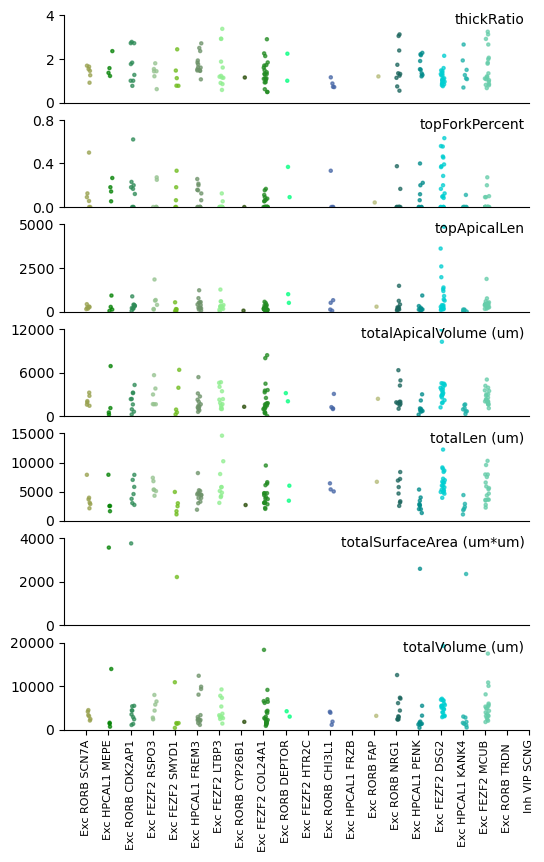

In [14]:
fig = plt.figure( figsize=(6, 50) )
x_axis = np.ones(X.shape[0])
dotsize = 20
nFeatures = X.shape[1]
nCluster = 53

n=30
ax = plt.subplot(nFeatures,1,n+1)
x = predictCluster+np.random.rand(np.sum(  predictCluster.count() ))/5
c= clusterColors_NeuronTable[predictCluster]
scatter = ax.scatter(x,X[:, n], c= clusterColors_NeuronTable[predictCluster], alpha = 0.7,s=dotsize, marker='.')
ax.set_xlim([-1,20])
ax.set_ylim([-0,4])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# plt.yscale('log')
plt.xticks([])
plt.yticks([0,2,4])
plt.text(0.99, 0.9, plotMorphFeats[n],transform=ax.transAxes,ha='right',fontsize=10)

n=31
ax = plt.subplot(nFeatures,1,n+1)
x = predictCluster+np.random.rand(np.sum(  predictCluster.count() ))/5
c= clusterColors_NeuronTable[predictCluster]
scatter = ax.scatter(x,X[:, n], c= clusterColors_NeuronTable[predictCluster], alpha = 0.7,s=dotsize, marker='.')
ax.set_xlim([-1,20])
ax.set_ylim([-0,0.8])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# plt.yscale('log')
plt.xticks([])
plt.yticks([0,0.4,0.8])
plt.text(0.99, 0.9, plotMorphFeats[n],transform=ax.transAxes,ha='right',fontsize=10)

n=32
ax = plt.subplot(nFeatures,1,n+1)
x = predictCluster+np.random.rand(np.sum(  predictCluster.count() ))/5
c= clusterColors_NeuronTable[predictCluster]
scatter = ax.scatter(x,X[:, n], c= clusterColors_NeuronTable[predictCluster], alpha = 0.7,s=dotsize, marker='.')
ax.set_xlim([-1,20])
ax.set_ylim([-0,5000])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# plt.yscale('log')
plt.xticks([])
plt.yticks([0,2500,5000])
plt.text(0.99, 0.9, plotMorphFeats[n],transform=ax.transAxes,ha='right',fontsize=10)

n=33
ax = plt.subplot(nFeatures,1,n+1)
x = predictCluster+np.random.rand(np.sum(  predictCluster.count() ))/5
c= clusterColors_NeuronTable[predictCluster]
scatter = ax.scatter(x,X[:, n], c= clusterColors_NeuronTable[predictCluster], alpha = 0.7,s=dotsize, marker='.')
ax.set_xlim([-1,20])
ax.set_ylim([-0,12000])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# plt.yscale('log')
plt.xticks([])
plt.yticks([0,6000,12000])
plt.text(0.99, 0.9, plotMorphFeats[n]+' (um)',transform=ax.transAxes,ha='right',fontsize=10)

n=34
ax = plt.subplot(nFeatures,1,n+1)
x = predictCluster+np.random.rand(np.sum(  predictCluster.count() ))/5
c= clusterColors_NeuronTable[predictCluster]
scatter = ax.scatter(x,X[:, n], c= clusterColors_NeuronTable[predictCluster], alpha = 0.7,s=dotsize, marker='.')
ax.set_xlim([-1,20])
ax.set_ylim([-0,15000])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# plt.yscale('log')
plt.xticks([])
plt.yticks([0,5000,10000,15000])
plt.text(0.99, 0.9, plotMorphFeats[n]+' (um)',transform=ax.transAxes,ha='right',fontsize=10)

n=35
ax = plt.subplot(nFeatures,1,n+1)
x = predictCluster+np.random.rand(np.sum(  predictCluster.count() ))/5
c= clusterColors_NeuronTable[predictCluster]
scatter = ax.scatter(x,X[:, n], c= clusterColors_NeuronTable[predictCluster], alpha = 0.7,s=dotsize, marker='.')
ax.set_xlim([-1,20])
ax.set_ylim([-0,4000])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# plt.yscale('log')
plt.xticks([])
plt.yticks([0,2000,4000])
plt.text(0.99, 0.9, plotMorphFeats[n]+' (um*um)',transform=ax.transAxes,ha='right',fontsize=10)

n=36
ax = plt.subplot(nFeatures,1,n+1)
x = predictCluster+np.random.rand(np.sum(  predictCluster.count() ))/5
c= clusterColors_NeuronTable[predictCluster]
scatter = ax.scatter(x,X[:, n], c= clusterColors_NeuronTable[predictCluster], alpha = 0.7,s=dotsize, marker='.')
ax.set_xlim([-1,20])
ax.set_ylim([-0,20000])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# plt.yscale('log')
plt.xticks([])
plt.yticks([0,10000,20000])
plt.text(0.99, 0.9, plotMorphFeats[n]+' (um)',transform=ax.transAxes,ha='right',fontsize=10)

plt.xticks(range(nCluster), clusterNames, rotation=90, fontsize=8)
ax.set_xlim([-1,20])

plt.savefig('./figures/morphFeatCmp_byCluster3.png',dpi=600);
plt.savefig('./figures/morphFeatCmp_byCluster3.pdf');